# Set up Environment

In [1]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=d9a0b7b225193015667280e19e0c876f37104955ec6d20a75e7ffbe13f536557
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [2]:
# Import Necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix,
                             roc_auc_score,
                             average_precision_score)
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score, cohen_kappa_score, brier_score_loss
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import umap

import xgboost as xgb

import warnings
import time
warnings.filterwarnings("ignore")

from multiprocessing import Pool
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from collections import Counter

# Load Processed Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# set up table for all loans
df = pd.read_csv('/content/drive/My Drive/MBS Study/df_final.csv')
df

Mounted at /content/drive


,Loan Sequence Number,Monthly Reporting Period,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Current Interest Rate,Delinquency Due to Disaster,Interest Bearing UPB,Original UPB,...,Occupancy Status_S,Property Type_CO,Property Type_CP,Property Type_MH,Property Type_PU,Property Type_SF,Property Valuation Method_1.0,Property Valuation Method_2.0,Property Valuation Method_3.0,Property Valuation Method_9.0
0,F11Q10000044,2011-02-01,135000.00,0,0.0,360.0,4.625,0,135000.00,135000.0,...,False,False,False,False,True,False,False,False,False,True
1,F11Q10000044,2011-03-01,135000.00,0,1.0,359.0,4.625,0,135000.00,135000.0,...,False,False,False,False,True,False,False,False,False,True
2,F11Q10000044,2011-04-01,135000.00,0,2.0,358.0,4.625,0,135000.00,135000.0,...,False,False,False,False,True,False,False,False,False,True
3,F11Q10000044,2011-05-01,134000.00,0,3.0,357.0,4.625,0,134000.00,135000.0,...,False,False,False,False,True,False,False,False,False,True
4,F11Q10000044,2011-06-01,134000.00,0,4.0,356.0,4.625,0,134000.00,135000.0,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014603,F19Q40515256,2022-11-01,115037.14,16,34.0,326.0,4.125,0,115037.14,118000.0,...,False,False,False,False,False,True,False,True,False,False
2014604,F19Q40515256,2022-12-01,115037.14,17,35.0,325.0,4.125,0,115037.14,118000.0,...,False,False,False,False,False,True,False,True,False,False
2014605,F19Q40515256,2023-01-01,115037.14,18,36.0,324.0,4.125,0,115037.14,118000.0,...,False,False,False,False,False,True,False,True,False,False
2014606,F19Q40515256,2023-02-01,115037.14,19,37.0,323.0,4.125,0,115037.14,118000.0,...,False,False,False,False,False,True,False,True,False,False


In [4]:
# Define columns of different types
columns_orig = [
       'Original UPB', 'Mortgage Insurance Percentage (MI %)',
       'Original Loan-to-Value (LTV)', 'Original Interest Rate', 'Super Conforming Flag', 'Credit Score',
       'Original Debt-to-Income (DTI) Ratio',
       'Number of Borrowers', 'Number of Units', 'Property Valuation Method',
       'Valid DTI Ratio', 'Channel_B', 'Channel_C', 'Channel_R', 'Loan Purpose_C',
       'Loan Purpose_N', 'Loan Purpose_P', 'First Time Homebuyer Flag_N',
       'First Time Homebuyer Flag_Y', 'Occupancy Status_I',
       'Occupancy Status_P', 'Occupancy Status_S', 'Property Type_CO',
       'Property Type_CP', 'Property Type_MH', 'Property Type_PU',
       'Property Type_SF']

columns_monthly = [
       'Monthly Reporting Period',
       'Current Actual UPB', 'Current Loan Delinquency Status', 'Loan Age',
       'Remaining Months to Legal Maturity',
       'Current Interest Rate', 'Delinquency Due to Disaster', 'Interest Bearing UPB',
       'Label']

columns_categorical_final = [
       'Valid DTI Ratio',
       'Super Conforming Flag',
       'Delinquency Due to Disaster',
       'Channel',
       'Loan Purpose',
       'First Time Homebuyer Flag',
       'Occupancy Status',
       'Property Type',
       'Property Valuation Method']

columns_continuous = [
       'Current Actual UPB', 'Current Loan Delinquency Status', 'Loan Age',
       'Remaining Months to Legal Maturity', 'Current Interest Rate',
       'Interest Bearing UPB', 'Original UPB',
       'Mortgage Insurance Percentage (MI %)', 'Original Loan-to-Value (LTV)',
       'Original Interest Rate',
       'Credit Score',
       'Original Debt-to-Income (DTI) Ratio', 'Number of Borrowers',
       'Number of Units','Valid DTI Ratio',
       'Housing Price', 'CPI', 'Unemployment_Rate', 'Recession'
]

columns_to_process = ['Current Actual UPB', 'Current Loan Delinquency Status', 'Loan Age',
       'Remaining Months to Legal Maturity', 'Current Interest Rate',
       'Delinquency Due to Disaster', 'Interest Bearing UPB', 'Original UPB',
       'Mortgage Insurance Percentage (MI %)', 'Original Loan-to-Value (LTV)',
       'Original Interest Rate', 'Super Conforming Flag', 'Credit Score',
       'Original Debt-to-Income (DTI) Ratio', 'Number of Borrowers',
       'Number of Units', 'Valid DTI Ratio', 'Housing Price', 'CPI',
       'Unemployment_Rate', 'Recession', 'Channel_B', 'Channel_C', 'Channel_R',
       'Loan Purpose_C', 'Loan Purpose_N', 'Loan Purpose_P',
       'First Time Homebuyer Flag_N', 'First Time Homebuyer Flag_Y',
       'Occupancy Status_I', 'Occupancy Status_P', 'Occupancy Status_S',
       'Property Type_CO', 'Property Type_CP', 'Property Type_MH',
       'Property Type_PU', 'Property Type_SF', 'Property Valuation Method_1.0',
       'Property Valuation Method_2.0', 'Property Valuation Method_3.0',
       'Property Valuation Method_9.0']

## Create shifted label

In [5]:
# Convert 'Monthly Reporting Period' to datetime type for proper sorting and manipulation
df['Monthly Reporting Period'] = pd.to_datetime(df['Monthly Reporting Period'])

# Sort the DataFrame by 'Loan Sequence Number' and 'Monthly Reporting Period' to ensure correct label alignment
df.sort_values(by=['Loan Sequence Number', 'Monthly Reporting Period'], inplace=True)

# Group by 'Loan Sequence Number' and shift 'Label' up by one to create the 'label_target'
df['label_target'] = df.groupby('Loan Sequence Number')['Label'].shift(-1)

# Drop rows where 'label_target' is NaN, indicating no subsequent month data for the same loan sequence number
df = df.dropna(subset=['label_target'])
df = df.drop(columns = {'Label'})
df = df.reset_index(drop = True)

In [6]:
df['target_0&1'] = df['label_target'].apply(lambda x: 0 if x in [0, 1] else 1)

# Create Windowed dataset: Gaussian

In [7]:
def gaussian_weights(window_size, std_dev):
    # Creates a series of weights for a Gaussian distribution
    # The most recent time point (the last in the sequence) gets the highest weight
    return np.exp(-0.5 * ((np.arange(window_size) - window_size + 1) / std_dev) ** 2)

def apply_gaussian_rolling(group, window_size=12, std_dev=3):
    weights = gaussian_weights(window_size, std_dev)
    # Initialize a DataFrame to hold the weighted averages
    weighted_averages = pd.DataFrame(index=group.index)
    # Calculate the weighted average for each feature
    for column in columns_to_process:
        # Prepend zeros for padding if there are not enough past months
        padded_series = np.concatenate((np.zeros(window_size - 1), group[column].to_numpy()))
        # Apply convolution to calculate the weighted average using Gaussian weights
        weighted_avg = np.convolve(padded_series, weights[::-1], mode='valid') / np.convolve(np.ones_like(padded_series), weights[::-1], mode='valid')
        weighted_averages[column] = weighted_avg
    return weighted_averages

# Apply the function to each group and store the result
window_size = 12  # This includes the current month and the past 11 months
std_dev = 2  # Standard deviation for the Gaussian weights

# Apply the transformation and update the original columns
transformed_df = df.groupby('Loan Sequence Number').apply(lambda x: apply_gaussian_rolling(x, window_size, std_dev)).reset_index(level=0, drop=True)
transformed_df[['Loan Sequence Number', 'Monthly Reporting Period','label_target','target_0&1']] = df[['Loan Sequence Number', 'Monthly Reporting Period','label_target','target_0&1']]
transformed_df.head()

,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Current Interest Rate,Delinquency Due to Disaster,Interest Bearing UPB,Original UPB,Mortgage Insurance Percentage (MI %),Original Loan-to-Value (LTV),...,Property Type_PU,Property Type_SF,Property Valuation Method_1.0,Property Valuation Method_2.0,Property Valuation Method_3.0,Property Valuation Method_9.0,Loan Sequence Number,Monthly Reporting Period,label_target,target_0&1
0,44900.795304,0.0,0.000000,119.735454,1.538268,0.0,44900.795304,44900.795304,0.0,18.292917,...,0.332598,0.0,0.0,0.0,0.0,0.332598,F11Q10000044,2011-02-01,0.0,0
1,84525.608084,0.0,0.332598,225.069023,2.895785,0.0,84525.608084,84525.608084,0.0,34.436359,...,0.626116,0.0,0.0,0.0,0.0,0.626116,F11Q10000044,2011-03-01,0.0,0
2,111759.317081,0.0,0.958714,297.066131,3.828791,0.0,111759.317081,111759.317081,0.0,45.531574,...,0.827847,0.0,0.0,0.0,0.0,0.827847,F11Q10000044,2011-04-01,0.0,0
3,126003.872579,0.0,1.786561,335.110695,4.328194,0.0,126003.872579,126336.471063,0.0,51.470414,...,0.935826,0.0,0.0,0.0,0.0,0.935826,F11Q10000044,2011-05-01,0.0,0
4,131787.017298,0.0,2.722387,350.379301,4.536376,0.0,131787.017298,132413.132913,0.0,53.946091,...,0.980838,0.0,0.0,0.0,0.0,0.980838,F11Q10000044,2011-06-01,0.0,0


## Standard Scaling the Continuous Data

In [8]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the data and then transform
transformed_df[columns_continuous] = scaler.fit_transform(transformed_df[columns_continuous])

# If you want to transform your DataFrame and store the scaled values directly back into it
transformed_df[columns_continuous] = scaler.fit_transform(transformed_df[columns_continuous].values)
transformed_df

,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Current Interest Rate,Delinquency Due to Disaster,Interest Bearing UPB,Original UPB,Mortgage Insurance Percentage (MI %),Original Loan-to-Value (LTV),...,Property Type_PU,Property Type_SF,Property Valuation Method_1.0,Property Valuation Method_2.0,Property Valuation Method_3.0,Property Valuation Method_9.0,Loan Sequence Number,Monthly Reporting Period,label_target,target_0&1
0,-1.379562,-0.251999,-1.222673,-4.936423,-3.831353,0.0,-1.379562,-1.418707,-0.542256,-1.966172,...,0.332598,0.0,0.0,0.0,0.0,0.332598,F11Q10000044,2011-02-01,0.0,0
1,-1.004142,-0.251999,-1.209790,-2.323970,-1.891984,0.0,-1.004142,-1.062078,-0.542256,-1.515169,...,0.626116,0.0,0.0,0.0,0.0,0.626116,F11Q10000044,2011-03-01,0.0,0
2,-0.746120,-0.251999,-1.185536,-0.538318,-0.559077,0.0,-0.746120,-0.816970,-0.542256,-1.205199,...,0.827847,0.0,0.0,0.0,0.0,0.827847,F11Q10000044,2011-04-01,0.0,0
3,-0.611161,-0.251999,-1.153469,0.405252,0.154376,0.0,-0.611161,-0.685773,-0.542256,-1.039285,...,0.935826,0.0,0.0,0.0,0.0,0.935826,F11Q10000044,2011-05-01,0.0,0
4,-0.556370,-0.251999,-1.117219,0.783940,0.451788,0.0,-0.556370,-0.631082,-0.542256,-0.970121,...,0.980838,0.0,0.0,0.0,0.0,0.980838,F11Q10000044,2011-06-01,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973862,-0.715064,3.073285,0.005162,0.236393,-0.135909,0.0,-0.715064,-0.760803,-0.542256,-1.834669,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2022-10-01,0.0,0
1973863,-0.715064,3.316048,0.043897,0.211591,-0.135909,0.0,-0.715064,-0.760803,-0.542256,-1.834669,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2022-11-01,0.0,0
1973864,-0.715064,3.558810,0.082633,0.186789,-0.135909,0.0,-0.715064,-0.760803,-0.542256,-1.834669,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2022-12-01,0.0,0
1973865,-0.715064,3.801573,0.121369,0.161987,-0.135909,0.0,-0.715064,-0.760803,-0.542256,-1.834669,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2023-01-01,0.0,0


## Logistic Regression

[[361154  30121]
 [   353   3146]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    391275
           1       0.09      0.90      0.17      3499

    accuracy                           0.92    394774
   macro avg       0.55      0.91      0.57    394774
weighted avg       0.99      0.92      0.95    394774

Accuracy: 0.9228064664846216


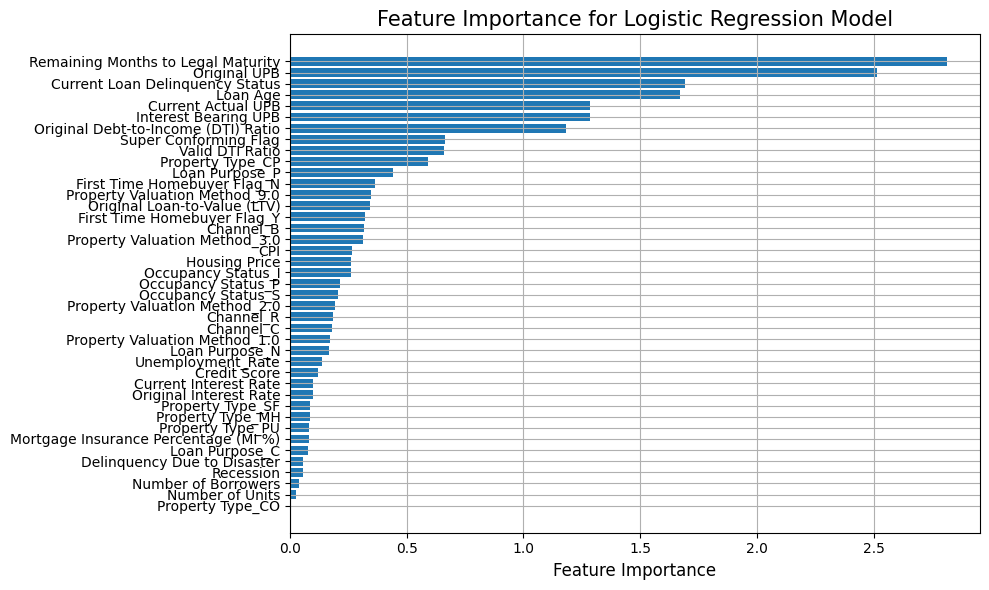

In [9]:
# Step 1: Split the data into features and target
X = transformed_df.drop(['Loan Sequence Number','Monthly Reporting Period','label_target','target_0&1'], axis=1)
y = transformed_df['target_0&1']

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that first oversamples the minority class and then trains a logistic regression model
pipeline = make_pipeline(
    # SMOTE(random_state=42),  # This will oversample the minority class
    # StandardScaler(),        # This will standardize the features
    LogisticRegression(class_weight='balanced')  # This sets the class weight to 'balanced'
)

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test data
predictions = pipeline.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

# Get the coefficients from the logistic model
logistic_model = pipeline.steps[-1][1]
coefficients = logistic_model.coef_[0]

# Get the feature names
feature_names = X_train.columns

# Create a series to hold the coefficients and feature names
importance = pd.Series(coefficients, index=feature_names)

# Sort the features by the absolute value of their coefficient in descending order
importance_sorted = importance.abs().sort_values(ascending=False)

# Get the sorted indices from the sorted series directly
sorted_indices = importance_sorted.index

# Create the plot
plt.figure(figsize=(10, 6))  # Increase the figure size
pos = np.arange(len(sorted_indices))
plt.barh(pos, importance_sorted[sorted_indices], align='center')  # Use sorted indices directly
plt.yticks(pos, sorted_indices, fontsize=10)  # Use sorted indices for y-ticks
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importance for Logistic Regression Model', fontsize=15)
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Logistic Regression + Backward Selection

Optimization terminated successfully.
         Current function value: 0.040544
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.040544
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.040544
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.040544
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.040544
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.040544
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.040544
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.040545
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.040545
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.

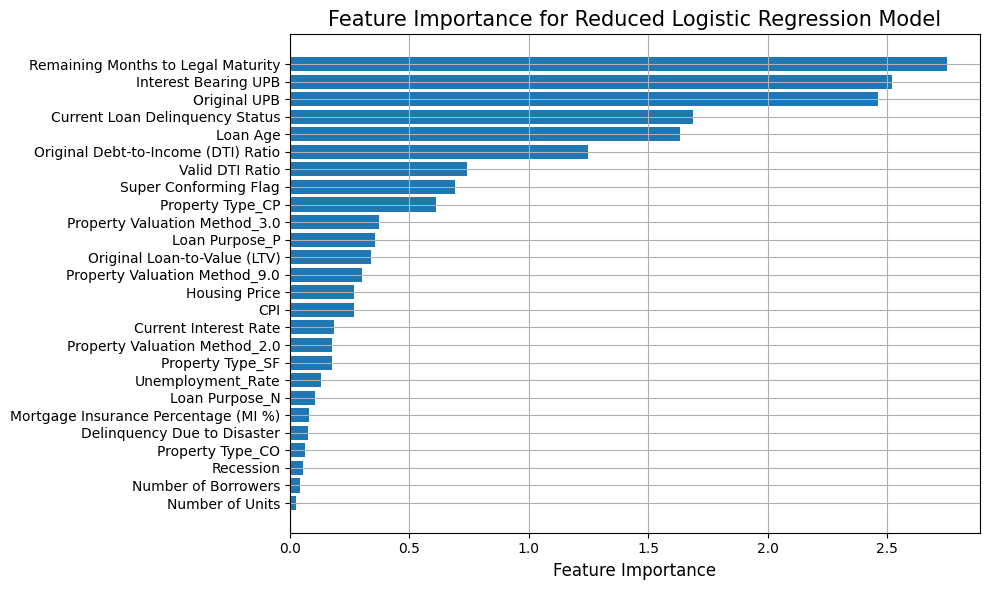

In [11]:
# Adding a constant to the model (intercept)
X_train_scaled = sm.add_constant(X_train)
X_test_scaled = sm.add_constant(X_test)

# Fit the initial model with all features
logit_model = sm.Logit(y_train, X_train_scaled).fit()

# Set a threshold for p-values
pval_threshold = 0.05

# Perform backward elimination
columns_to_keep = X_train_scaled.columns.tolist()
while True:
    # Get p-values and find the feature with the maximum p-value
    p_values = logit_model.pvalues
    max_pval = p_values.max()
    if max_pval > pval_threshold:
        # Find the name of the variable (column) with the highest p-value
        excluded_feature = p_values.idxmax()
        # Remove the feature from the list
        columns_to_keep.remove(excluded_feature)
        # Drop the feature from the training set
        X_train_scaled = X_train_scaled[columns_to_keep]
        # Refit the model without the excluded feature
        logit_model = sm.Logit(y_train, X_train_scaled).fit()
    else:
        break

# Now X_train_scaled and X_test_scaled only contain the features that met the p-value threshold
# Ensure the test set matches the final columns
X_test_scaled = X_test_scaled[columns_to_keep]

# Train a logistic regression model with the reduced set of features
reduced_logistic_model = LogisticRegression(class_weight='balanced')
reduced_logistic_model.fit(X_train_scaled, y_train)

# Predict on the test data with reduced features
predictions = reduced_logistic_model.predict(X_test_scaled)

# Evaluation
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

# Exclude the intercept from the coefficients array
coefficients = reduced_logistic_model.coef_[0][1:]  # Skip the intercept coefficient

# Ensure that the number of feature names matches the number of coefficients
# We are getting the feature names from the model where we dropped the columns
feature_names = X_train_scaled.columns[1:]  # Skip the 'const' column

# Now the lengths should match
importance = pd.Series(coefficients, index=feature_names)

# Sort the features by the absolute value of their coefficient in descending order
importance_sorted_reduced = importance.abs().sort_values(ascending=False)

# Get the sorted indices from the sorted series directly
sorted_indices_reduced = importance_sorted_reduced.index

# Create the plot
plt.figure(figsize=(10, 6))  # Increase the figure size
pos = np.arange(len(sorted_indices_reduced))
plt.barh(pos, importance_sorted_reduced[sorted_indices_reduced], align='center')  # Use sorted indices directly
plt.yticks(pos, sorted_indices_reduced, fontsize=10)  # Use sorted indices for y-ticks
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importance for Reduced Logistic Regression Model', fontsize=15)
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## XGBoost

[[360523  30752]
 [   311   3188]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    391275
           1       0.09      0.91      0.17      3499

    accuracy                           0.92    394774
   macro avg       0.55      0.92      0.56    394774
weighted avg       0.99      0.92      0.95    394774

F1 Score: 0.17030369400892115
Accuracy: 0.921314473597552


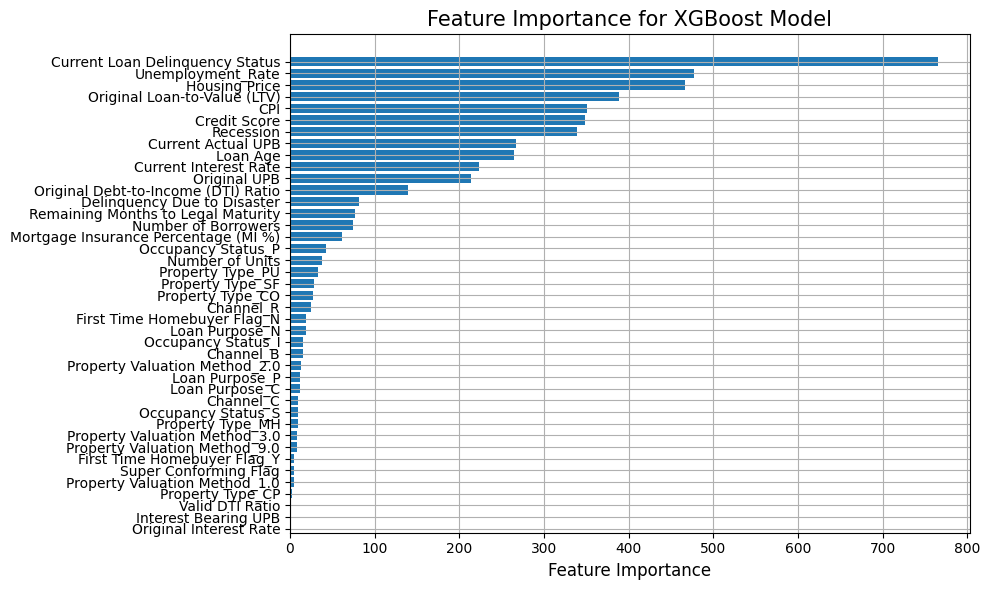

In [12]:
# Calculate the scale_pos_weight
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# Train the XGBoost classifier with scale_pos_weight
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight  # Add this line
)

# Fit the classifier to the balanced training data
xgb_clf.fit(X_train, y_train)

# Predict on the test data
xgb_predictions = xgb_clf.predict(X_test)

# Evaluate the classifier
print(confusion_matrix(y_test, xgb_predictions))
print(classification_report(y_test, xgb_predictions))
print("F1 Score:", f1_score(y_test, xgb_predictions))
print("Accuracy:", accuracy_score(y_test, xgb_predictions))

# If you want to plot feature importance
# Get the feature importances
importances = xgb_clf.get_booster().get_score(importance_type='weight')

# Convert the importances into a pandas Series with feature names as the index
feature_importances = pd.Series(importances, index=X_train.columns)

# Sort the features by their importance in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))  # Increase the figure size
pos = np.arange(len(sorted_importances))
plt.barh(pos, sorted_importances, align='center')
plt.yticks(pos, sorted_importances.index, fontsize=10)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importance for XGBoost Model', fontsize=15)
plt.gca().invert_yaxis()  # Invert the y-axis so the bar with the highest value is on top
plt.grid(True)
plt.tight_layout()
plt.show()

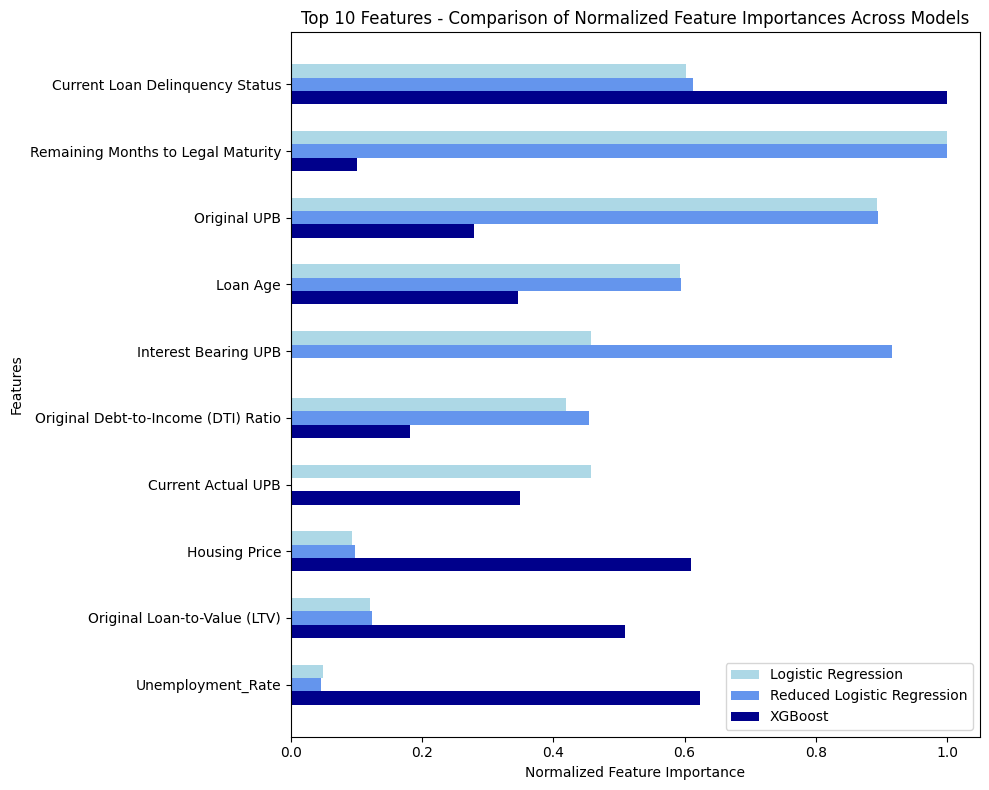

In [23]:

# Normalize the importances within each model
norm_logistic = importance_sorted / importance_sorted.max()
norm_reduced_logistic = importance_sorted_reduced / importance_sorted_reduced.max()
norm_xgboost = sorted_importances / sorted_importances.max()

# Combine the normalized series into a DataFrame, filling missing values with 0
combined_norm_importances = pd.DataFrame({
    'Logistic Regression': norm_logistic,
    'Reduced Logistic Regression': norm_reduced_logistic,
    'XGBoost': norm_xgboost
}).fillna(0)

# Sum the normalized importances
combined_norm_importances['Total Importance'] = combined_norm_importances.sum(axis=1)

# Sort by 'Total Importance' and select the top 10 features
top_features = combined_norm_importances.sort_values(by='Total Importance', ascending=False).head(10)

# Create the horizontal bar chart
n_top_features = len(top_features)
index = np.arange(n_top_features)
bar_width = 0.2

plt.figure(figsize=(10, 8))

# Define a gradient of blue colors
blue_gradient = ['#add8e6', '#6495ed', '#00008b']  # light blue, medium blue, dark blue

plt.barh(index, top_features['Logistic Regression'], bar_width, color=blue_gradient[0], label='Logistic Regression')
plt.barh(index + bar_width, top_features['Reduced Logistic Regression'], bar_width, color=blue_gradient[1], label='Reduced Logistic Regression')
plt.barh(index + 2 * bar_width, top_features['XGBoost'], bar_width, color=blue_gradient[2], label='XGBoost')

plt.ylabel('Features')
plt.xlabel('Normalized Feature Importance')
plt.title('Top 10 Features - Comparison of Normalized Feature Importances Across Models')
plt.yticks(index + bar_width, top_features.index)
plt.gca().invert_yaxis()  # Invert y-axis to place highest value on top
plt.legend()

plt.tight_layout()
plt.show()

# Create Windowed dataset: Exponential

In [12]:
def exponential_weights(window_size, decay):
    # Creates a series of weights for an exponential distribution
    # The most recent time point (the last in the sequence) gets the highest weight
    return np.exp(-np.arange(window_size) * decay)

def apply_exponential_rolling(group, window_size=12, decay=0.1):
    weights = exponential_weights(window_size, decay)
    # Initialize a DataFrame to hold the weighted averages
    weighted_averages = pd.DataFrame(index=group.index)
    # Calculate the weighted average for each feature
    for column in columns_to_process:
        # Prepend zeros for padding if there are not enough past months
        padded_series = np.concatenate((np.zeros(window_size - 1), group[column].to_numpy()))
        # Apply convolution to calculate the weighted average using exponential weights
        weighted_avg = np.convolve(padded_series, weights, mode='valid') / np.convolve(np.ones_like(padded_series), weights, mode='valid')
        # Append the weighted average to the DataFrame
        weighted_averages[column] = weighted_avg
    return weighted_averages

# Apply the function to each group and store the result
window_size = 12  # This includes the current month and the past 11 months
decay = 0.1  # Decay factor for the exponential weights

# Apply the transformation and update the original columns
transformed_df_exp = df.groupby('Loan Sequence Number').apply(lambda x: apply_exponential_rolling(x, window_size, decay)).reset_index(level=0, drop=True)
transformed_df_exp[['Loan Sequence Number', 'Monthly Reporting Period', 'label_target', 'target_0&1']] = df[['Loan Sequence Number', 'Monthly Reporting Period', 'label_target', 'target_0&1']]
transformed_df_exp.head()

,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Current Interest Rate,Delinquency Due to Disaster,Interest Bearing UPB,Original UPB,Mortgage Insurance Percentage (MI %),Original Loan-to-Value (LTV),...,Property Type_PU,Property Type_SF,Property Valuation Method_1.0,Property Valuation Method_2.0,Property Valuation Method_3.0,Property Valuation Method_9.0,Loan Sequence Number,Monthly Reporting Period,label_target,target_0&1
0,18384.147333,0.0,0.000000,49.024393,0.629827,0.0,18384.147333,18384.147333,0.0,7.489838,...,0.136179,0.0,0.0,0.0,0.0,0.136179,F11Q10000044,2011-02-01,0.0,0
1,35018.811738,0.0,0.136179,93.247319,1.199719,0.0,35018.811738,35018.811738,0.0,14.266923,...,0.259399,0.0,0.0,0.0,0.0,0.259399,F11Q10000044,2011-03-01,0.0,0
2,50070.478528,0.0,0.395577,133.125699,1.715378,0.0,50070.478528,50070.478528,0.0,20.399084,...,0.370892,0.0,0.0,0.0,0.0,0.370892,F11Q10000044,2011-04-01,0.0,0
3,63553.610975,0.0,0.766470,169.072970,2.181965,0.0,63553.610975,63689.789844,0.0,25.947692,...,0.471776,0.0,0.0,0.0,0.0,0.471776,F11Q10000044,2011-05-01,0.0,0
4,75753.653725,0.0,1.238246,201.463227,2.604151,0.0,75753.653725,76013.052331,0.0,30.968281,...,0.563060,0.0,0.0,0.0,0.0,0.563060,F11Q10000044,2011-06-01,0.0,0


## Standard Scaling the Continuous Data

In [13]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the data and then transform
transformed_df_exp[columns_continuous] = scaler.fit_transform(transformed_df_exp[columns_continuous])

# If you want to transform your DataFrame and store the scaled values directly back into it
transformed_df_exp[columns_continuous] = scaler.fit_transform(transformed_df_exp[columns_continuous].values)
transformed_df_exp

,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Current Interest Rate,Delinquency Due to Disaster,Interest Bearing UPB,Original UPB,Mortgage Insurance Percentage (MI %),Original Loan-to-Value (LTV),...,Property Type_PU,Property Type_SF,Property Valuation Method_1.0,Property Valuation Method_2.0,Property Valuation Method_3.0,Property Valuation Method_9.0,Loan Sequence Number,Monthly Reporting Period,label_target,target_0&1
0,-1.516583,-0.224777,-1.131916,-3.789298,-3.283887,0.0,-1.516583,-1.528423,-0.528822,-2.016117,...,0.136179,0.0,0.0,0.0,0.0,0.136179,F11Q10000044,2011-02-01,0.0,0
1,-1.358860,-0.224777,-1.126570,-3.119574,-2.719977,0.0,-1.358860,-1.379673,-0.528822,-1.834841,...,0.259399,0.0,0.0,0.0,0.0,0.259399,F11Q10000044,2011-03-01,0.0,0
2,-1.216145,-0.224777,-1.116387,-2.515645,-2.209730,0.0,-1.216145,-1.245077,-0.528822,-1.670816,...,0.370892,0.0,0.0,0.0,0.0,0.370892,F11Q10000044,2011-04-01,0.0,0
3,-1.088303,-0.224777,-1.101827,-1.971250,-1.748040,0.0,-1.088303,-1.123290,-0.528822,-1.522400,...,0.471776,0.0,0.0,0.0,0.0,0.471776,F11Q10000044,2011-05-01,0.0,0
4,-0.972626,-0.224777,-1.083307,-1.480723,-1.330285,0.0,-0.972626,-1.013093,-0.528822,-1.388108,...,0.563060,0.0,0.0,0.0,0.0,0.563060,F11Q10000044,2011-06-01,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973862,-0.600155,2.804441,-0.006679,0.486108,0.174602,0.0,-0.600155,-0.637636,-0.528822,-1.601246,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2022-10-01,0.0,0
1973863,-0.600155,3.088506,0.032578,0.470963,0.174602,0.0,-0.600155,-0.637636,-0.528822,-1.601246,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2022-11-01,0.0,0
1973864,-0.600155,3.372571,0.071834,0.455819,0.174602,0.0,-0.600155,-0.637636,-0.528822,-1.601246,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2022-12-01,0.0,0
1973865,-0.600155,3.656635,0.111090,0.440675,0.174602,0.0,-0.600155,-0.637636,-0.528822,-1.601246,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2023-01-01,0.0,0


## Logistic Regression

[[354677  36598]
 [   459   3040]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    391275
           1       0.08      0.87      0.14      3499

    accuracy                           0.91    394774
   macro avg       0.54      0.89      0.55    394774
weighted avg       0.99      0.91      0.94    394774

Accuracy: 0.9061311028588509


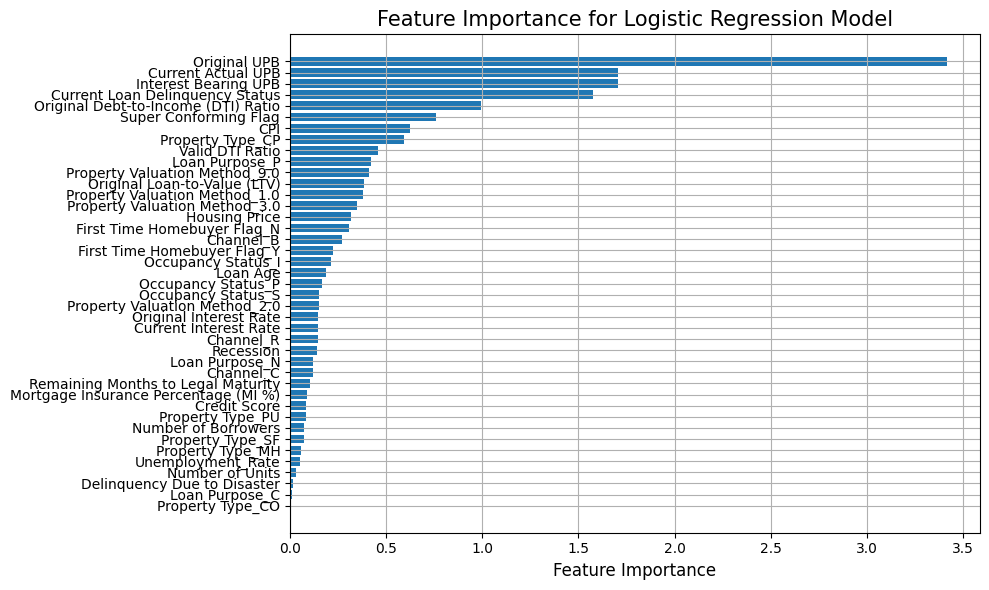

In [14]:
# Step 1: Split the data into features and target
X = transformed_df_exp.drop(['Loan Sequence Number','Monthly Reporting Period','label_target','target_0&1'], axis=1)
y = transformed_df_exp['target_0&1']

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that first oversamples the minority class and then trains a logistic regression  model
pipeline = make_pipeline(
    # SMOTE(random_state=42),  # This will oversample the minority class
    # StandardScaler(),        # This will standardize the features
    LogisticRegression(class_weight='balanced')  # This sets the class weight to 'balanced'
)

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test data
predictions = pipeline.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

# Get the coefficients from the logistic model
logistic_model = pipeline.steps[-1][1]
coefficients = logistic_model.coef_[0]

# Get the feature names
feature_names = X_train.columns

# Create a series to hold the coefficients and feature names
importance = pd.Series(coefficients, index=feature_names)

# Sort the features by the absolute value of their coefficient in descending order
importance_sorted = importance.abs().sort_values(ascending=False)

# Get the sorted indices from the sorted series directly
sorted_indices = importance_sorted.index

# Create the plot
plt.figure(figsize=(10, 6))  # Increase the figure size
pos = np.arange(len(sorted_indices))
plt.barh(pos, importance_sorted[sorted_indices], align='center')  # Use sorted indices directly
plt.yticks(pos, sorted_indices, fontsize=10)  # Use sorted indices for y-ticks
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importance for Logistic Regression Model', fontsize=15)
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Logistic Regression + Backward Elimination

In [15]:
# # Adding a constant to the model (intercept)
# X_train_scaled = sm.add_constant(X_train)
# X_test_scaled = sm.add_constant(X_test)

# # Fit the initial model with all features
# logit_model = sm.Logit(y_train, X_train_scaled).fit()

# # Set a threshold for p-values
# pval_threshold = 0.05

# # Perform backward elimination
# columns_to_keep = X_train_scaled.columns.tolist()
# while True:
#     # Get p-values and find the feature with the maximum p-value
#     p_values = logit_model.pvalues
#     max_pval = p_values.max()
#     if max_pval > pval_threshold:
#         # Find the name of the variable (column) with the highest p-value
#         excluded_feature = p_values.idxmax()
#         # Remove the feature from the list
#         columns_to_keep.remove(excluded_feature)
#         # Drop the feature from the training set
#         X_train_scaled = X_train_scaled[columns_to_keep]
#         # Refit the model without the excluded feature
#         logit_model = sm.Logit(y_train, X_train_scaled).fit()
#     else:
#         break

# # Now X_train_scaled and X_test_scaled only contain the features that met the p-value threshold
# # Ensure the test set matches the final columns
# X_test_scaled = X_test_scaled[columns_to_keep]

# # Train a logistic regression model with the reduced set of features
# reduced_logistic_model = LogisticRegression(class_weight='balanced')
# reduced_logistic_model.fit(X_train_scaled, y_train)

# # Predict on the test data with reduced features
# predictions = reduced_logistic_model.predict(X_test_scaled)

# # Evaluation
# print(confusion_matrix(y_test, predictions))
# print(classification_report(y_test, predictions))
# print("Accuracy:", accuracy_score(y_test, predictions))

# # Exclude the intercept from the coefficients array
# coefficients = reduced_logistic_model.coef_[0][1:]  # Skip the intercept coefficient

# # Ensure that the number of feature names matches the number of coefficients
# # We are getting the feature names from the model where we dropped the columns
# feature_names = X_train_scaled.columns[1:]  # Skip the 'const' column

# # Now the lengths should match
# importance = pd.Series(coefficients, index=feature_names)

# # Sort the features by the absolute value of their coefficient in descending order
# importance_sorted = importance.abs().sort_values(ascending=False)

# # Get the sorted indices from the sorted series directly
# sorted_indices = importance_sorted.index

# # Create the plot
# plt.figure(figsize=(10, 6))  # Increase the figure size
# pos = np.arange(len(sorted_indices))
# plt.barh(pos, importance_sorted[sorted_indices], align='center')  # Use sorted indices directly
# plt.yticks(pos, sorted_indices, fontsize=10)  # Use sorted indices for y-ticks
# plt.xlabel('Feature Importance', fontsize=12)
# plt.title('Feature Importance for Logistic Regression Model', fontsize=15)
# plt.grid(True)
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

## XGBoost

[[359941  31334]
 [   270   3229]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    391275
           1       0.09      0.92      0.17      3499

    accuracy                           0.92    394774
   macro avg       0.55      0.92      0.56    394774
weighted avg       0.99      0.92      0.95    394774

F1 Score: 0.16967053754400713
Accuracy: 0.9199440692649465


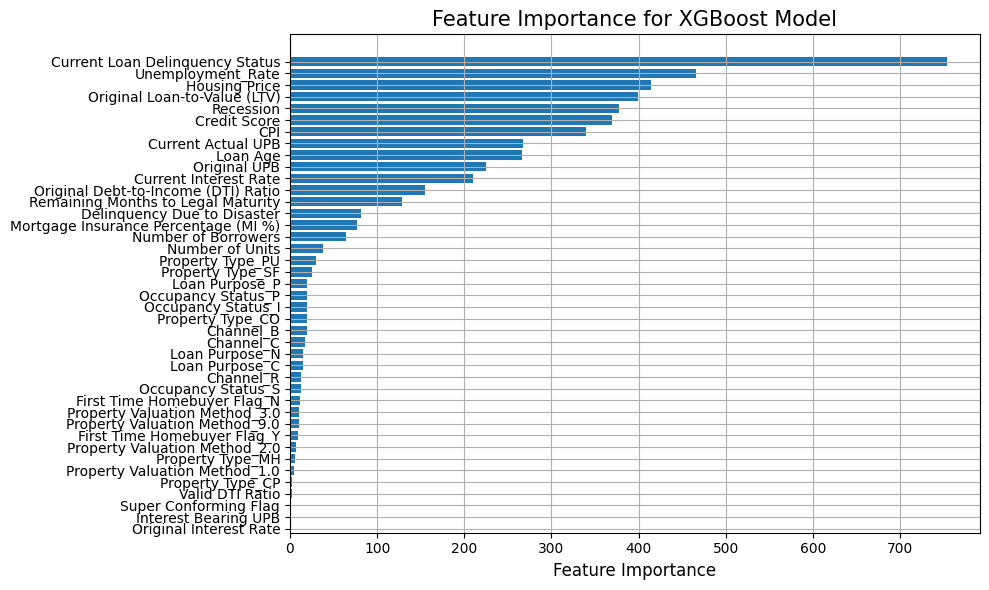

In [16]:
# Calculate the scale_pos_weight
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# Train the XGBoost classifier with scale_pos_weight
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight  # Add this line
)

# Fit the classifier to the balanced training data
xgb_clf.fit(X_train, y_train)


# Predict on the test data
xgb_predictions = xgb_clf.predict(X_test)

# Evaluate the classifier
print(confusion_matrix(y_test, xgb_predictions))
print(classification_report(y_test, xgb_predictions))
print("F1 Score:", f1_score(y_test, xgb_predictions))
print("Accuracy:", accuracy_score(y_test, xgb_predictions))

# If you want to plot feature importance
# Get the feature importances
importances = xgb_clf.get_booster().get_score(importance_type='weight')

# Convert the importances into a pandas Series with feature names as the index
feature_importances = pd.Series(importances, index=X_train.columns)

# Sort the features by their importance in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))  # Increase the figure size
pos = np.arange(len(sorted_importances))
plt.barh(pos, sorted_importances, align='center')
plt.yticks(pos, sorted_importances.index, fontsize=10)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importance for XGBoost Model', fontsize=15)
plt.gca().invert_yaxis()  # Invert the y-axis so the bar with the highest value is on top
plt.grid(True)
plt.tight_layout()
plt.show()

# Create Windowed dataset: Linear

In [17]:
def linear_weights(window_size):
    # Creates a series of weights for an exponential distribution
    # The most recent time point (the last in the sequence) gets the highest weight
    return np.exp(-np.arange(window_size) * decay)

def apply_linear_rolling(group, window_size=12):
    weights = linear_weights(window_size)
    # Initialize a DataFrame to hold the weighted averages
    weighted_averages = pd.DataFrame(index=group.index)
    # Calculate the weighted average for each feature
    for column in columns_to_process:
        # Prepend zeros for padding if there are not enough past months
        padded_series = np.concatenate((np.zeros(window_size - 1), group[column].to_numpy()))
        # Apply convolution to calculate the weighted average using exponential weights
        weighted_avg = np.convolve(padded_series, weights, mode='valid') / np.convolve(np.ones_like(padded_series), weights, mode='valid')
        # Append the weighted average to the DataFrame
        weighted_averages[column] = weighted_avg
    return weighted_averages

# Apply the function to each group and store the result
window_size = 12  # This includes the current month and the past 11 months

# Apply the transformation and update the original columns
transformed_df_linear = df.groupby('Loan Sequence Number').apply(lambda x: apply_linear_rolling(x, window_size)).reset_index(level=0, drop=True)
transformed_df_linear[['Loan Sequence Number', 'Monthly Reporting Period', 'label_target', 'target_0&1']] = df[['Loan Sequence Number', 'Monthly Reporting Period', 'label_target', 'target_0&1']]
transformed_df_linear.head()

,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Current Interest Rate,Delinquency Due to Disaster,Interest Bearing UPB,Original UPB,Mortgage Insurance Percentage (MI %),Original Loan-to-Value (LTV),...,Property Type_PU,Property Type_SF,Property Valuation Method_1.0,Property Valuation Method_2.0,Property Valuation Method_3.0,Property Valuation Method_9.0,Loan Sequence Number,Monthly Reporting Period,label_target,target_0&1
0,18384.147333,0.0,0.000000,49.024393,0.629827,0.0,18384.147333,18384.147333,0.0,7.489838,...,0.136179,0.0,0.0,0.0,0.0,0.136179,F11Q10000044,2011-02-01,0.0,0
1,35018.811738,0.0,0.136179,93.247319,1.199719,0.0,35018.811738,35018.811738,0.0,14.266923,...,0.259399,0.0,0.0,0.0,0.0,0.259399,F11Q10000044,2011-03-01,0.0,0
2,50070.478528,0.0,0.395577,133.125699,1.715378,0.0,50070.478528,50070.478528,0.0,20.399084,...,0.370892,0.0,0.0,0.0,0.0,0.370892,F11Q10000044,2011-04-01,0.0,0
3,63553.610975,0.0,0.766470,169.072970,2.181965,0.0,63553.610975,63689.789844,0.0,25.947692,...,0.471776,0.0,0.0,0.0,0.0,0.471776,F11Q10000044,2011-05-01,0.0,0
4,75753.653725,0.0,1.238246,201.463227,2.604151,0.0,75753.653725,76013.052331,0.0,30.968281,...,0.563060,0.0,0.0,0.0,0.0,0.563060,F11Q10000044,2011-06-01,0.0,0


## Standard Scaling the Continuous Data

In [18]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the data and then transform
transformed_df_linear[columns_continuous] = scaler.fit_transform(transformed_df_linear[columns_continuous])

# If you want to transform your DataFrame and store the scaled values directly back into it
transformed_df_linear[columns_continuous] = scaler.fit_transform(transformed_df_linear[columns_continuous].values)
transformed_df_linear

,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Current Interest Rate,Delinquency Due to Disaster,Interest Bearing UPB,Original UPB,Mortgage Insurance Percentage (MI %),Original Loan-to-Value (LTV),...,Property Type_PU,Property Type_SF,Property Valuation Method_1.0,Property Valuation Method_2.0,Property Valuation Method_3.0,Property Valuation Method_9.0,Loan Sequence Number,Monthly Reporting Period,label_target,target_0&1
0,-1.516583,-0.224777,-1.131916,-3.789298,-3.283887,0.0,-1.516583,-1.528423,-0.528822,-2.016117,...,0.136179,0.0,0.0,0.0,0.0,0.136179,F11Q10000044,2011-02-01,0.0,0
1,-1.358860,-0.224777,-1.126570,-3.119574,-2.719977,0.0,-1.358860,-1.379673,-0.528822,-1.834841,...,0.259399,0.0,0.0,0.0,0.0,0.259399,F11Q10000044,2011-03-01,0.0,0
2,-1.216145,-0.224777,-1.116387,-2.515645,-2.209730,0.0,-1.216145,-1.245077,-0.528822,-1.670816,...,0.370892,0.0,0.0,0.0,0.0,0.370892,F11Q10000044,2011-04-01,0.0,0
3,-1.088303,-0.224777,-1.101827,-1.971250,-1.748040,0.0,-1.088303,-1.123290,-0.528822,-1.522400,...,0.471776,0.0,0.0,0.0,0.0,0.471776,F11Q10000044,2011-05-01,0.0,0
4,-0.972626,-0.224777,-1.083307,-1.480723,-1.330285,0.0,-0.972626,-1.013093,-0.528822,-1.388108,...,0.563060,0.0,0.0,0.0,0.0,0.563060,F11Q10000044,2011-06-01,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973862,-0.600155,2.804441,-0.006679,0.486108,0.174602,0.0,-0.600155,-0.637636,-0.528822,-1.601246,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2022-10-01,0.0,0
1973863,-0.600155,3.088506,0.032578,0.470963,0.174602,0.0,-0.600155,-0.637636,-0.528822,-1.601246,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2022-11-01,0.0,0
1973864,-0.600155,3.372571,0.071834,0.455819,0.174602,0.0,-0.600155,-0.637636,-0.528822,-1.601246,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2022-12-01,0.0,0
1973865,-0.600155,3.656635,0.111090,0.440675,0.174602,0.0,-0.600155,-0.637636,-0.528822,-1.601246,...,0.000000,1.0,0.0,1.0,0.0,0.000000,F19Q40515256,2023-01-01,0.0,0


## Logistic Regression

[[354677  36598]
 [   459   3040]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    391275
           1       0.08      0.87      0.14      3499

    accuracy                           0.91    394774
   macro avg       0.54      0.89      0.55    394774
weighted avg       0.99      0.91      0.94    394774

Accuracy: 0.9061311028588509


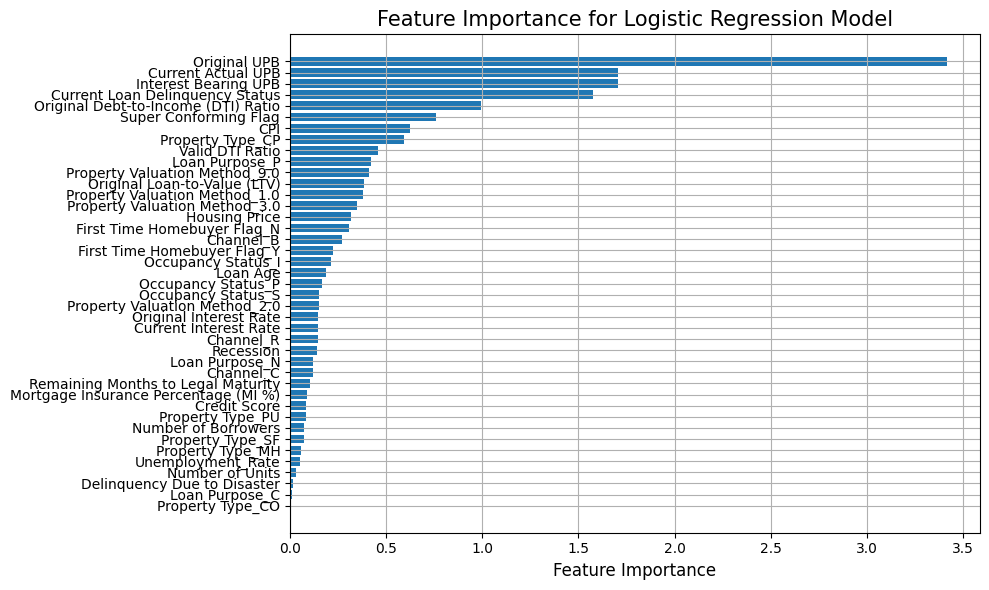

In [19]:
# Step 1: Split the data into features and target
X = transformed_df_linear.drop(['Loan Sequence Number','Monthly Reporting Period','label_target','target_0&1'], axis=1)
y = transformed_df_linear['target_0&1']

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that first oversamples the minority class and then trains a logistic regression  model
pipeline = make_pipeline(
    # SMOTE(random_state=42),  # This will oversample the minority class
    # StandardScaler(),        # This will standardize the features
    LogisticRegression(class_weight='balanced')  # This sets the class weight to 'balanced'
)

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test data
predictions = pipeline.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

# Get the coefficients from the logistic model
logistic_model = pipeline.steps[-1][1]
coefficients = logistic_model.coef_[0]

# Get the feature names
feature_names = X_train.columns

# Create a series to hold the coefficients and feature names
importance = pd.Series(coefficients, index=feature_names)

# Sort the features by the absolute value of their coefficient in descending order
importance_sorted = importance.abs().sort_values(ascending=False)

# Get the sorted indices from the sorted series directly
sorted_indices = importance_sorted.index

# Create the plot
plt.figure(figsize=(10, 6))  # Increase the figure size
pos = np.arange(len(sorted_indices))
plt.barh(pos, importance_sorted[sorted_indices], align='center')  # Use sorted indices directly
plt.yticks(pos, sorted_indices, fontsize=10)  # Use sorted indices for y-ticks
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importance for Logistic Regression Model', fontsize=15)
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Logistic Regression + Backward Elimination

In [20]:
# # Adding a constant to the model (intercept)
# X_train_scaled = sm.add_constant(X_train)
# X_test_scaled = sm.add_constant(X_test)

# # Fit the initial model with all features
# logit_model = sm.Logit(y_train, X_train_scaled).fit()

# # Set a threshold for p-values
# pval_threshold = 0.05

# # Perform backward elimination
# columns_to_keep = X_train_scaled.columns.tolist()
# while True:
#     # Get p-values and find the feature with the maximum p-value
#     p_values = logit_model.pvalues
#     max_pval = p_values.max()
#     if max_pval > pval_threshold:
#         # Find the name of the variable (column) with the highest p-value
#         excluded_feature = p_values.idxmax()
#         # Remove the feature from the list
#         columns_to_keep.remove(excluded_feature)
#         # Drop the feature from the training set
#         X_train_scaled = X_train_scaled[columns_to_keep]
#         # Refit the model without the excluded feature
#         logit_model = sm.Logit(y_train, X_train_scaled).fit()
#     else:
#         break

# # Now X_train_scaled and X_test_scaled only contain the features that met the p-value threshold
# # Ensure the test set matches the final columns
# X_test_scaled = X_test_scaled[columns_to_keep]

# # Train a logistic regression model with the reduced set of features
# reduced_logistic_model = LogisticRegression(class_weight='balanced')
# reduced_logistic_model.fit(X_train_scaled, y_train)

# # Predict on the test data with reduced features
# predictions = reduced_logistic_model.predict(X_test_scaled)

# # Evaluation
# print(confusion_matrix(y_test, predictions))
# print(classification_report(y_test, predictions))
# print("Accuracy:", accuracy_score(y_test, predictions))

# # Exclude the intercept from the coefficients array
# coefficients = reduced_logistic_model.coef_[0][1:]  # Skip the intercept coefficient

# # Ensure that the number of feature names matches the number of coefficients
# # We are getting the feature names from the model where we dropped the columns
# feature_names = X_train_scaled.columns[1:]  # Skip the 'const' column

# # Now the lengths should match
# importance = pd.Series(coefficients, index=feature_names)

# # Sort the features by the absolute value of their coefficient in descending order
# importance_sorted = importance.abs().sort_values(ascending=False)

# # Get the sorted indices from the sorted series directly
# sorted_indices = importance_sorted.index

# # Create the plot
# plt.figure(figsize=(10, 6))  # Increase the figure size
# pos = np.arange(len(sorted_indices))
# plt.barh(pos, importance_sorted[sorted_indices], align='center')  # Use sorted indices directly
# plt.yticks(pos, sorted_indices, fontsize=10)  # Use sorted indices for y-ticks
# plt.xlabel('Feature Importance', fontsize=12)
# plt.title('Feature Importance for Logistic Regression Model', fontsize=15)
# plt.grid(True)
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

## XGBoost

[[359941  31334]
 [   270   3229]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    391275
           1       0.09      0.92      0.17      3499

    accuracy                           0.92    394774
   macro avg       0.55      0.92      0.56    394774
weighted avg       0.99      0.92      0.95    394774

F1 Score: 0.16967053754400713
Accuracy: 0.9199440692649465


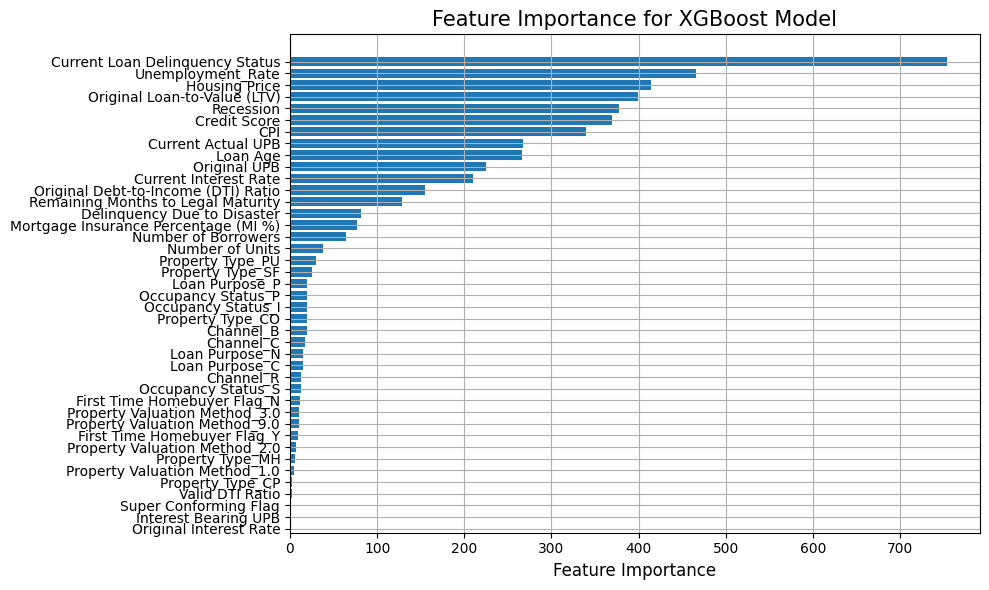

In [21]:
# Calculate the scale_pos_weight
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# Train the XGBoost classifier with scale_pos_weight
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight  # Add this line
)

# Fit the classifier to the balanced training data
xgb_clf.fit(X_train, y_train)


# Predict on the test data
xgb_predictions = xgb_clf.predict(X_test)

# Evaluate the classifier
print(confusion_matrix(y_test, xgb_predictions))
print(classification_report(y_test, xgb_predictions))
print("F1 Score:", f1_score(y_test, xgb_predictions))
print("Accuracy:", accuracy_score(y_test, xgb_predictions))

# If you want to plot feature importance
# Get the feature importances
importances = xgb_clf.get_booster().get_score(importance_type='weight')

# Convert the importances into a pandas Series with feature names as the index
feature_importances = pd.Series(importances, index=X_train.columns)

# Sort the features by their importance in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))  # Increase the figure size
pos = np.arange(len(sorted_importances))
plt.barh(pos, sorted_importances, align='center')
plt.yticks(pos, sorted_importances.index, fontsize=10)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importance for XGBoost Model', fontsize=15)
plt.gca().invert_yaxis()  # Invert the y-axis so the bar with the highest value is on top
plt.grid(True)
plt.tight_layout()
plt.show()